### Introduction to Classification Lab 

In [1]:
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

We will revisit the HR dataset and see if we can use KNN to predict whether an employee is likely to leave the company

In [2]:
hr = pd.read_csv("data/HR_comma_sep.csv")
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


#### 1. Which is the target variable we want to predict?

left

#### 2. Create some exploratory visualizations to understand which factors are likely to contribute to an employee's departure

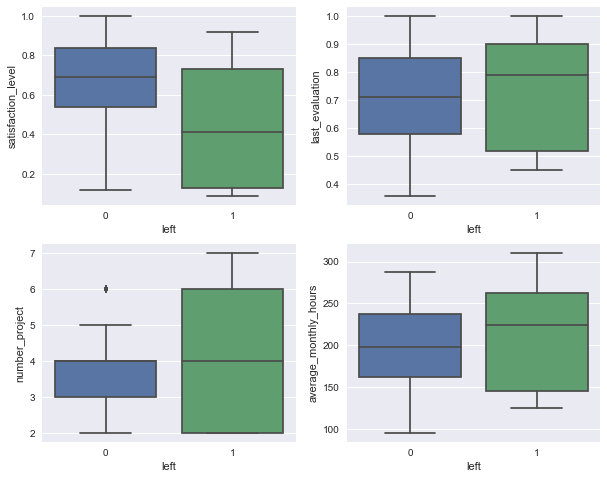

In [3]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
sns.boxplot(x="left", y="satisfaction_level", data=hr, ax=ax[0,0])
sns.boxplot(x="left", y="last_evaluation", data=hr, ax=ax[0,1])
sns.boxplot(x="left", y="number_project", data=hr, ax=ax[1,0])
sns.boxplot(x="left", y="average_monthly_hours", data=hr, ax=ax[1,1])

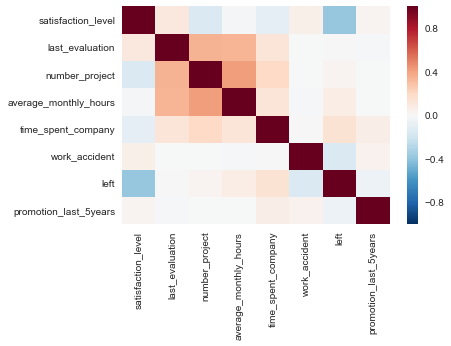

In [4]:
sns.heatmap(hr.corr())

Let's focus on the quantitative / continuous variables to begin with. Remember for KNN, we need to scale the predictors before we fit the model. In this example we are using Sklearn's StandardScaler() http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [5]:
factors = ["satisfaction_level", "last_evaluation", "number_project", "average_monthly_hours", "time_spent_company", "work_accident", "promotion_last_5years"]
X = StandardScaler().fit_transform(hr[factors])
y = hr["left"]

#### 3. Using train_test_split split the X and y data into training and testing sets 
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### 4. Create a KNN classifier using KNeighborsClassifier with 5 neighbors and fit the model using the training data
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [7]:
knn = KNeighborsClassifier(5).fit(X_train, y_train)

#### 5. Calculate the accuracy score for predictions on the training data 

In [8]:
train_preds = knn.predict(X_train)
metrics.accuracy_score(train_preds, y_train)

0.97617566005867185

#### 6. Calculate the accuracy score for predictions on the testing data

In [9]:
test_preds = knn.predict(X_test)
metrics.accuracy_score(test_preds, y_test)

0.96479999999999999

Note that test accuracy is lower than train accuracy which is expected but we want to make sure that the drop in accuracy is not dramatic which would be an indication of overfitting 

#### 7. Let's now compute the accuracy for the KNN model using cross-validation
Using KFold, create a model with 10 splits. Note that X and y are numpy arrays and to filter the rows we can directly use X_train = X[train_index] without .iloc which we needed to use for data frames. Print the accuracy for each fold as well as the mean accuracy across all the folds.
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [10]:
kf = KFold(n_splits=10, random_state=10, shuffle=True)
scores = []
for train_index, test_index in kf.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    knn = KNeighborsClassifier(5).fit(X_train, y_train)
    test_preds = knn.predict(X_test)
    accuracy = metrics.accuracy_score(test_preds, y_test)
    scores.append(accuracy)
    print("Accuracy: %f" % (accuracy))
print ("Mean Accuracy: %f" % np.mean(scores))

Accuracy: 0.953333
Accuracy: 0.952667
Accuracy: 0.963333
Accuracy: 0.962000
Accuracy: 0.970667
Accuracy: 0.968000
Accuracy: 0.967333
Accuracy: 0.972000
Accuracy: 0.960667
Accuracy: 0.967312
Mean Accuracy: 0.963731


#### 8. Now let's use GridSearchCV to identify the best value for n_neighbors using 10 fold cross validation. Use values for k between 2 and 10
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [11]:
k = range(2, 10)
params = {'n_neighbors': k }
gv = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = params,
    cv = kf
)
gv.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=10, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

#### 9. Which is the best parameter value for n_neighbors? 

In [12]:
gv.best_params_

{'n_neighbors': 2}

#### 10. Plot the mean_test_score against k

In [13]:
gv.cv_results_['mean_test_score']

array([ 0.97779852,  0.97139809,  0.96659777,  0.96373092,  0.96879792,
        0.96726448,  0.96813121,  0.96706447])

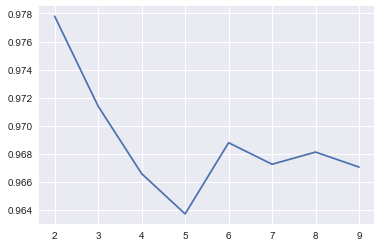

In [14]:
plt.plot(k, gv.cv_results_['mean_test_score'])

#### Bonus: Add the categorical variables and see whether they have an impact on the KNN model performance 